<a href="https://colab.research.google.com/github/zardemostoles/zardemostoles-uoc.edu/blob/master/TFG_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ficheros que se cargan para el Análisis Exploratorio de Datos

In [1]:
# Fichero de metadatos:
print ("Primeros registros del fichero de metadatos:")
!cat /content/drive/MyDrive/TFG/train.csv | head

Primeros registros del fichero de metadatos:
image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,0,4,1022,767
ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767
ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767
ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,0,24,1022,767
ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767
ISIC_0000006,-1,female,25.0,posterior torso,NV,benign,0,0,1022,767
ISIC_0000007,-1,female,25.0,posterior torso,NV,benign,0,16,1022,767
ISIC_0000008,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767
ISIC_0000009,-1,female,30.0,anterior torso,NV,benign,0,8,1022,767


In [2]:
# Fichero de tipo de tono de piel ITA:
print ("Primeros registros del fichero de tipo de tono de piel ITA:")
!cat /content/drive/MyDrive/TFG/TFG_tono_piel_ITA.csv | head

Primeros registros del fichero de tipo de tono de piel ITA:
image_name,tipo_ITA
ISIC_0000002,6
ISIC_0053467,1
ISIC_0053459,1
ISIC_0000000,6
ISIC_0053470,6
ISIC_0053515,1
ISIC_0053456,1
ISIC_0053506,1
ISIC_0053475,1


## Carga de módulos que se emplean en el notebook

In [3]:
# Se cargan las bibliotecas que se van a usar en el ejercicio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.gridspec import GridSpec

## Carga y preparación del dataframe Pandas

In [4]:
# Se crea el dataframe pandas con los metadatos 
# y se muestran las 5 primeras filas               
df_ISIC = pd.read_csv('/content/drive/MyDrive/TFG/train.csv')
df_ISIC.head(5)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,0,4,1022,767
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,0,24,1022,767
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767


In [5]:
# Se comprueba que no hay información de ID de paciente
df_ISIC["patient_id"].unique()

array([-1])

In [6]:
# Dimensiones del dataframe con los metadatos
df_ISIC.shape

(25331, 11)

In [7]:
# Se crea el dataframe pandas con los tipos de tono de piel ITA 
# y se muestran las 5 primeras filas               
df_ITA = pd.read_csv('/content/drive/MyDrive/TFG/TFG_tono_piel_ITA.csv')
df_ITA.head(5)

,image_name,tipo_ITA
0,ISIC_0000002,6
1,ISIC_0053467,1
2,ISIC_0053459,1
3,ISIC_0000000,6
4,ISIC_0053470,6


In [8]:
# Dimensiones del dataframe con los tipos de tono de piel ITA 
df_ITA.shape

(23218, 2)

In [9]:
# Se elimina la columna de ID de paciente
# y otras columnas no necesarias
df_ISIC = df_ISIC.drop(columns=["patient_id", "tfrecord", "width", "height"], axis=1)

In [10]:
# Se cuentan cuantas imágenes son "downsampled"
df_ISIC[df_ISIC['image_name'].str.contains("_downsampled")]['image_name'].count()

2074

In [11]:
# Se eliminan los registros con imágenes "downsampled"
df_ISIC = df_ISIC[df_ISIC['image_name'].str.contains("_downsampled")==False]

In [12]:
# Dimensiones del dataframe con los metadatos

In [13]:
# Se combinan los dataframes de metadatos y tipos de tono de piel
df_ISIC = df_ISIC.merge(df_ITA, on='image_name', how='left')

In [14]:
# Dimensiones del dataframe con datos combinados
df_ISIC.shape

(23257, 8)

## Análisis exploratorio de datos

In [15]:
# Se transforma el valor binario del diagnóstico a texto
df_ISIC['target'] = df_ISIC['target'].replace({0: "no melanoma", 1: "melanoma"})

In [16]:
# Porcentajes por diagnóstico
print("Propociones por diagnóstico:")
df_ISIC["target"].value_counts(normalize=True)

Propociones por diagnóstico:


no melanoma    0.821645
melanoma       0.178355
Name: target, dtype: float64

In [17]:
# Proporciones por diagnóstico
print("Propociones por diagnóstico:")
round(pd.crosstab(df_ISIC["anatom_site_general_challenge"],df_ISIC["target"], normalize='index')*100, 1)

Propociones por diagnóstico:


target,melanoma,no melanoma
anatom_site_general_challenge,,
anterior torso,19.2,80.8
head/neck,18.7,81.3
lateral torso,50.0,50.0
lower extremity,15.6,84.4
oral/genital,32.2,67.8
palms/soles,50.6,49.4
posterior torso,15.0,85.0
upper extremity,24.1,75.9


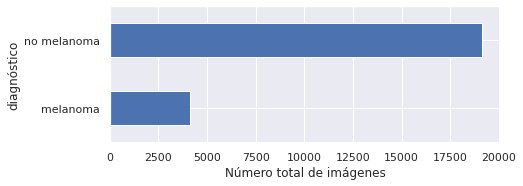

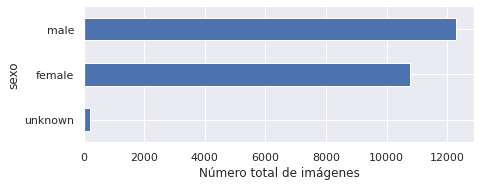

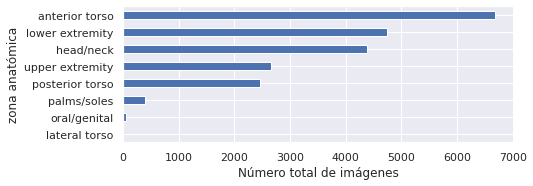

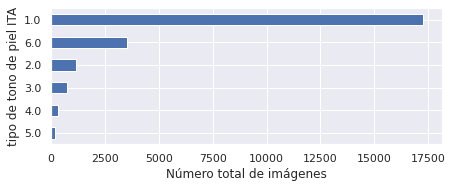

In [18]:
distribuciones = {
    "target": "diagnóstico",
    "sex": "sexo",
    "anatom_site_general_challenge": "zona anatómica",
    "tipo_ITA": "tipo de tono de piel ITA"
}

for key, value in distribuciones.items():
  ax = df_ISIC[key].value_counts().plot(kind='barh',
                                    figsize=(7,2.5),
                                    title=None);
  ax.set_ylabel(value);
  ax.set_xlabel("Número total de imágenes");
  ax.invert_yaxis();
  plt.show();

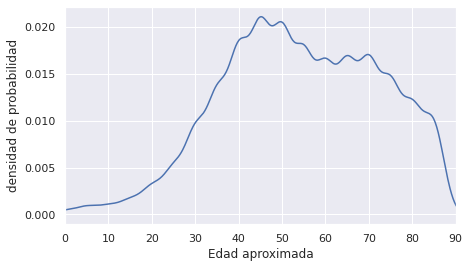

In [19]:
ax = df_ISIC["age_approx"].plot(kind='density', 
                           xlim=[0,90],
                           figsize=(7,4));
ax.set_xlabel("Edad aproximada");
ax.set_ylabel("densidad de probabilidad");
plt.show();


In [20]:
print("\nEstadísticos básicos de las variables del dataset:")
round(df_ISIC.describe(include='all'),3)


Estadísticos básicos de las variables del dataset:


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tipo_ITA
count,23257,23257,23034.000,21374,23257,23257,23257,23218.000
unique,23257,3,NaN,8,8,2,2,NaN
top,ISIC_0000000,male,NaN,anterior torso,NV,benign,no melanoma,NaN
freq,1,12279,NaN,6683,11559,19109,19109,NaN
mean,NaN,NaN,54.311,NaN,NaN,NaN,NaN,1.951
std,NaN,NaN,17.912,NaN,NaN,NaN,NaN,1.829
min,NaN,NaN,0.000,NaN,NaN,NaN,NaN,1.000
25%,NaN,NaN,40.000,NaN,NaN,NaN,NaN,1.000
50%,NaN,NaN,55.000,NaN,NaN,NaN,NaN,1.000
75%,NaN,NaN,70.000,NaN,NaN,NaN,NaN,2.000


In [21]:
round(pd.crosstab(index=df_ISIC['sex'], columns=df_ISIC['target'], normalize='index')*100,2)


target,melanoma,no melanoma
sex,,
female,17.33,82.67
male,18.30,81.70
unknown,16.67,83.33


In [22]:
round(pd.crosstab(index=df_ISIC['anatom_site_general_challenge'], columns=df_ISIC['target'], normalize='index')*100,2)

target,melanoma,no melanoma
anatom_site_general_challenge,,
anterior torso,19.21,80.79
head/neck,18.74,81.26
lateral torso,50.00,50.00
lower extremity,15.57,84.43
oral/genital,32.20,67.80
palms/soles,50.64,49.36
posterior torso,15.00,85.00
upper extremity,24.12,75.88


In [24]:
import scipy.stats as stats
df_ISIC2 = df_ISIC[df_ISIC["sex"]!="unknown"]
crosstab = pd.crosstab(df_ISIC["sex"], df_ISIC["target"])
# are these variables independent?
chi2, p, dof, ex = stats.chi2_contingency(crosstab)

print(f'Chi_square value {chi2}\n\np value {p}\n\ndegrees of freedom {dof}\n\n expected {ex}')



Chi_square value 3.8823676730180505

p value 0.1435339284540467

degrees of freedom 2

 expected [[ 1921.59573462  8852.40426538]
 [ 2190.01986499 10088.98013501]
 [   36.3844004    167.6155996 ]]


In [ ]:
from scipy.stats import pearsonr
pearsonr(df_ISIC)